In [ ]:
import sys, time, os, asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst_efd_client import EfdClient
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
def add_timestamp( data):
        """
        Adds a correct timestamp column in UTC format to the provided data if
        not present.

        Parameters
        ----------
        data : DataFrame
            The data to which the timestamp will be added.

        Returns
        -------
        DataFrame
            The data with the added 'snd_timestamp_utc' column.
        """
        if "snd_timestamp_utc" not in data.columns:
            data["snd_timestamp_utc"] = Time(
                data["private_sndStamp"], format="unix_tai"
            ).unix
        return data
def get_data(events_frame, client, train=False):
    table_dict={"m1m3_hp_actuator":"lsst.sal.MTM1M3.hardpointActuatorData",
                #"m1m3_hp_monitor": "lsst.sal.MTM1M3.hardpointMonitorData",
                "mtmount_elevation": "lsst.sal.MTMount.elevation",
                "mtmount_azimuth": "lsst.sal.MTMount.azimuth",
                "m1m3_ims": "lsst.sal.MTM1M3.imsData"}
    query_dict={}
    for key in table_dict.keys():
        query_dict[key]=[]
    for j , time in tqdm(enumerate(events_frame["times"])):
        event_time=Time(events_frame["times"][j]-2, format="unix")
        for key in table_dict.keys():

                query=getEfdData(client, 
                                 table_dict[key],  
                                begin=event_time, 
                                end=event_time, 
                                prePadding=20, 
                                postPadding=20)
                query["event_num"]=j
                query = add_timestamp(query)
                query["oscillation_bool"]=0
                query["delta_time"] = query["snd_timestamp_utc"] - events_frame["times"][j] +3 
                if train:
                    sel = (query["delta_time"] >= -5)
                    sel &= (query["delta_time"] < 1)
                    query.loc[sel,"oscillation_bool"]=1

                query_dict[key].append(query)
    for key in table_dict.keys():
        query_dict[key]=pd.concat(query_dict[key])
    sorted_keys = sorted(query_dict.keys())
    initial_key = sorted_keys[0]
    merged_df = query_dict[initial_key].sort_index()
    # Define your tolerance for matching
    tolerance = 0.03# pd.Timedelta('0.03 seconds')

    # Iterate over the remaining DataFrames and merge them
    for key in sorted_keys[1:]:
        merged_df = pd.merge_asof(merged_df, query_dict[key].sort_index(), 
                                  left_on="snd_timestamp_utc", 
                                  right_on="snd_timestamp_utc", tolerance=tolerance, direction='nearest',
                                  suffixes=('', "_"+key))
    merged_df.reset_index(drop=True, inplace=True)
    
    return merged_df

In [3]:
client = EfdClient("idf_efd")
events_frame=pd.read_csv('./sitcomtn81_data/231114_cleaned_oscillations_final.csv')

#merged_df = get_data(events_frame, client)



In [13]:
abs(events_frame["elevation_velocity"]).min()

2.187676206130015e-06

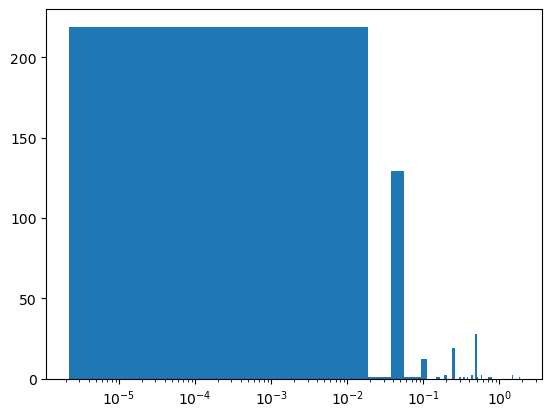

In [14]:
_=plt.hist(abs(events_frame["elevation_velocity"]), bins=100)
plt.xscale('log')

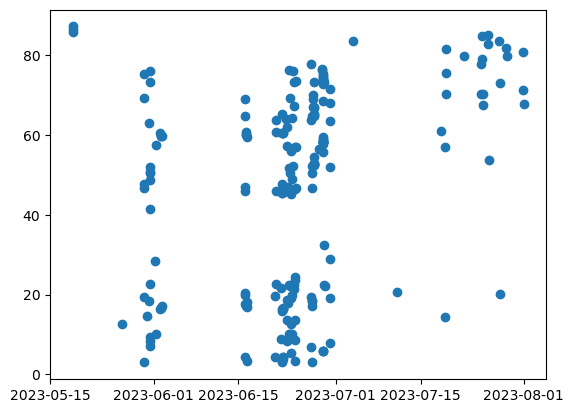

In [17]:
sel= (abs(events_frame["elevation_velocity"]) > 1e-2)
plt.scatter(Time(events_frame["times"][sel], format='unix').datetime,events_frame["elevation_position"][sel])

In [20]:
events_frame.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'times', 'heights', 'rmean_diff',
       'counts', 'actuators', 'slew_state', 'elevation_velocity',
       'azimuth_velocity', 'elevation_position', 'seq_num', 'day_obs',
       'day_obs_y', 'seq_num_y', 'osc_event_num', 'time', 'iso_time'],
      dtype='object')

In [19]:
plt.scatter(Time(events_frame["times"][sel], format='unix').datetime,events_frame["az_position"][sel])

KeyError: 'az_position'